## 1. Importing Necessary Libraries

In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

## 2. Loading the dataset(Train and Test)

In [0]:

# load train and test dataset
def load_dataset():
	# load dataset
  (X_train, y_train), (X_test, y_test)= tf.keras.datasets.cifar10.load_data()
	# one hot encode target values
  y_train = tf.keras.utils.to_categorical(y_train, num_classes)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes) 
  return X_train,y_train,X_test,y_test

In [6]:
X_train, y_train,X_test,y_test = load_dataset()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 


170500096/170498071 [==============================] - 4s 0us/step


In [7]:
X_train.shape

(50000, 32, 32, 3)

In [0]:
X_test.shape

(10000, 32, 32, 3)

## 3. Standardizing the dataset

In [0]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
  
X_train,X_test=prep_pixels(X_train,X_test)

## 4. Data Augumentation Example with Keras

Using TensorFlow backend.


(32, 32, 3)
(1, 32, 32, 3)


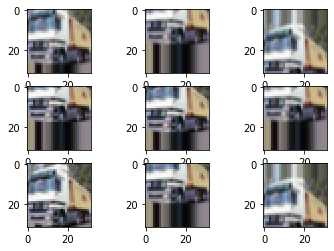

In [8]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
first_image=X_train[1]
print(first_image.shape)
first_img = expand_dims(first_image, 0)
print(first_img.shape)
#pyplot.imshow(first_img[0])

# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(first_img, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = (batch[0]*255).astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()


In [0]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')

## 5. Creating the DenseNet Basic Blocks

In [0]:
from keras import regularizers
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)
   
    flat = layers.Flatten()(output)    
    return flat


In [11]:
num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,num_filter, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, 64, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
sgd = tf.keras.optimizers.SGD(lr = 0.1,momentum = 0.9,nesterov = True)
model = Model(inputs=[input], outputs=[output])
model.compile(sgd,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 6. Running the model with data augumentation

Epoch 1/150
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
390/390 [==============================] - 136s 349ms/step - loss: 2.3141 - acc: 0.2117 - val_loss: 2.6096 - val_acc: 0.1708
Epoch 2/150
390/390 [==============================] - 122s 313ms/step - loss: 1.9130 - acc: 0.3178 - val_loss: 1.7375 - val_acc: 0.3758
Epoch 3/150
390/390 [==============================] - 123s 314ms/step - loss: 1.7047 - acc: 0.3766 - val_loss: 1.6098 - val_acc: 0.4104
Epoch 4/150
390/390 [==============================] - 123s 314ms/step - loss: 1.5894 - acc: 0.4215 - val_loss: 1.6173 - val_acc: 0.4313
Epoch 5/150
390/390 [==============================] - 122s 314ms/step - loss: 1.4993 - acc: 0.4568 - val_loss: 1.5374 - val_acc: 0.4562
Epoch 6/150
390/390 [==============================] - 122s 314ms/step - loss: 1.4132 - acc: 0.4902 - val_loss: 1.3912 - val_acc: 0.4986
Epoch 7/150
390/390 [==============================] - 122s 314ms/step - loss: 1.339

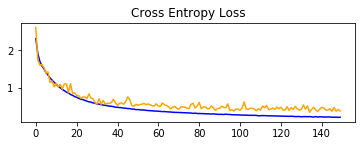

In [13]:
datagen = ImageDataGenerator( zoom_range=0.3,width_shift_range=0.1,rotation_range=15,height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=128)
# fit model
steps = int(X_train.shape[0] / 128)
history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=150, validation_data=(X_test, y_test), verbose=1)
# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)


In [15]:
from prettytable import PrettyTable
conclusion= PrettyTable()
conclusion.field_names = [ "Model", 'epochs','Train Loss','Test Loss',"Train Accuracy",'Test Accuracy']
conclusion.add_row(["CNN DenseNet",150, 0.2162, 0.3828,0.9253,0.8840])


print(conclusion)

+--------------+--------+------------+-----------+----------------+---------------+
|    Model     | epochs | Train Loss | Test Loss | Train Accuracy | Test Accuracy |
+--------------+--------+------------+-----------+----------------+---------------+
| CNN DenseNet |  150   |   0.2162   |   0.3828  |     0.9253     |     0.884     |
+--------------+--------+------------+-----------+----------------+---------------+
